In [52]:

%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import *
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


df = load_df()

version = "target"
target = "fix_two_sided_ptu"
train_set = "test"
test_set = "test"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of used features: 44
count    1.000000
mean     0.106805
std           NaN
min      0.106805
25%      0.106805
50%      0.106805
75%      0.106805
max      0.106805
Name: 0, dtype: float64


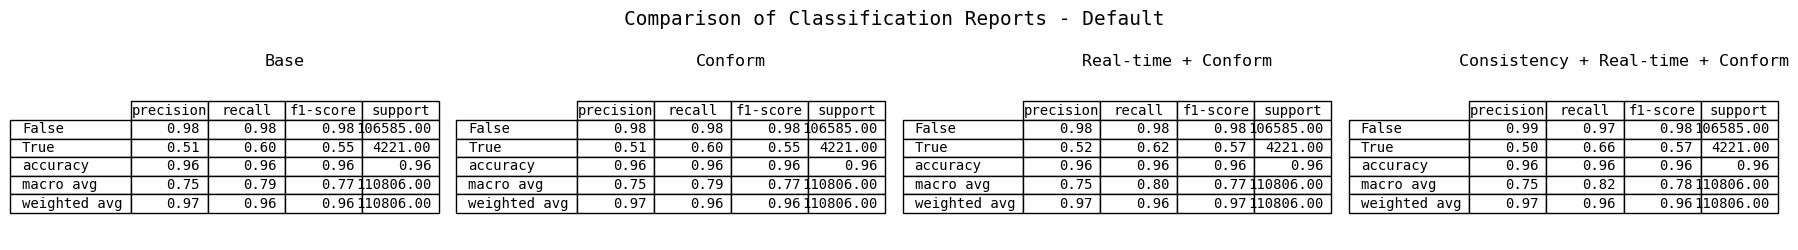

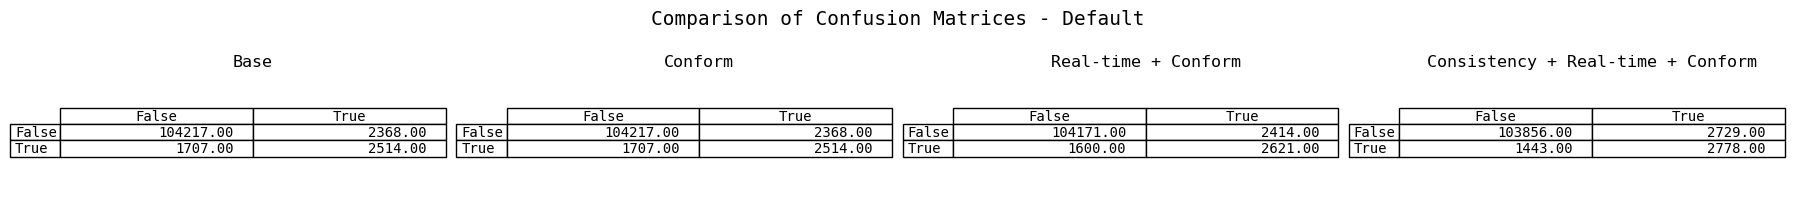

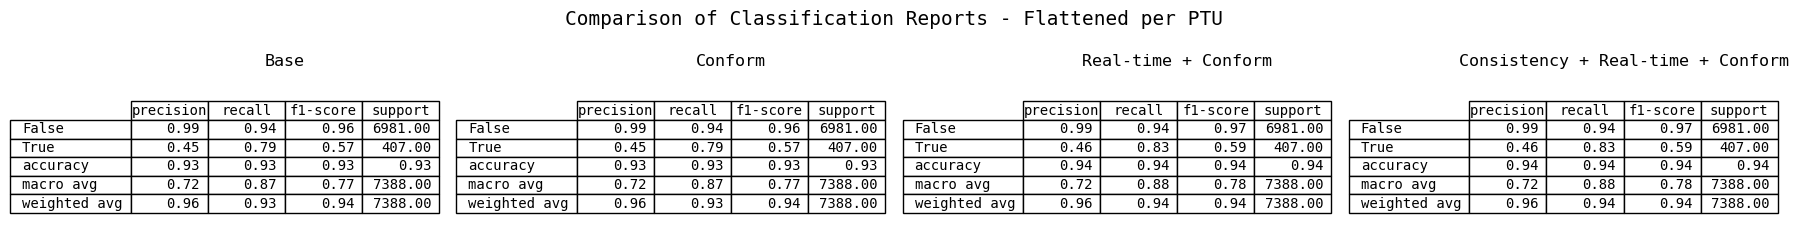

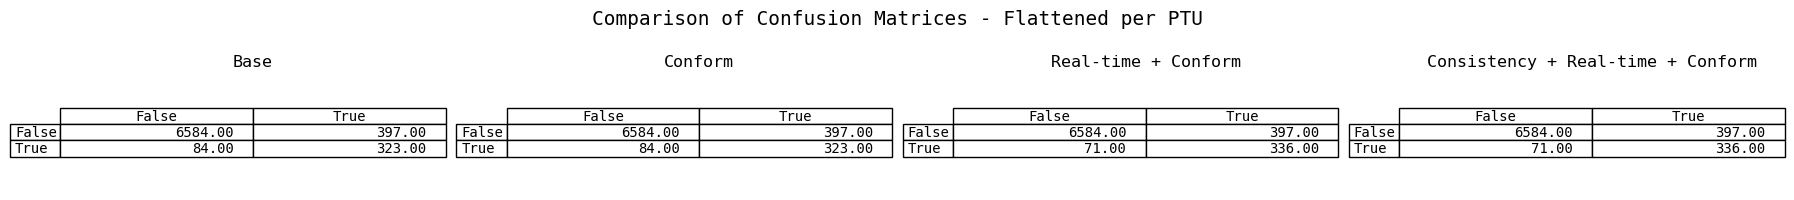

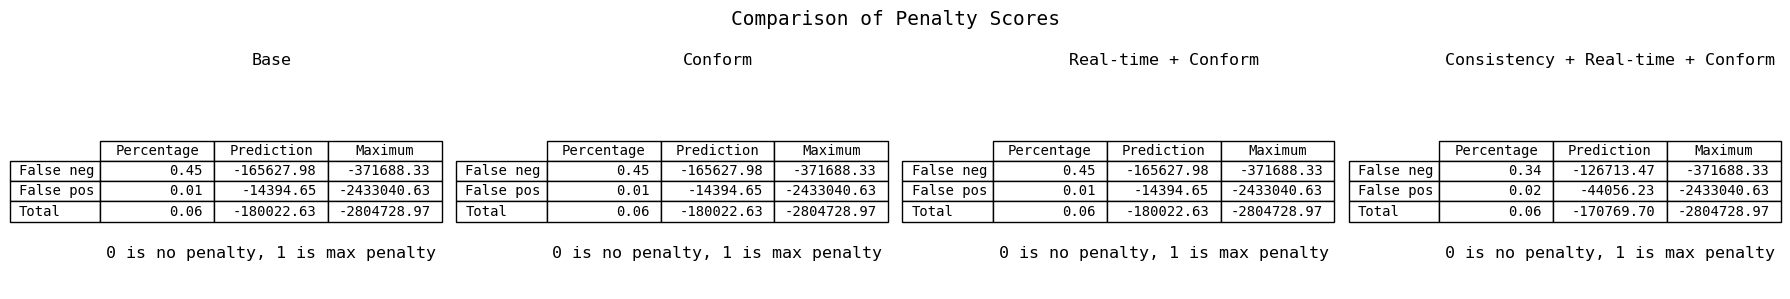

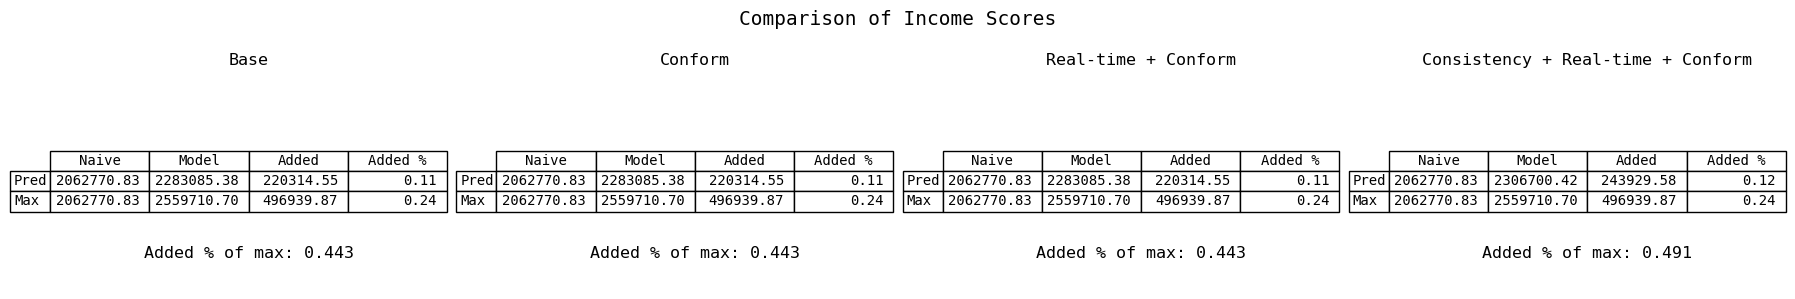

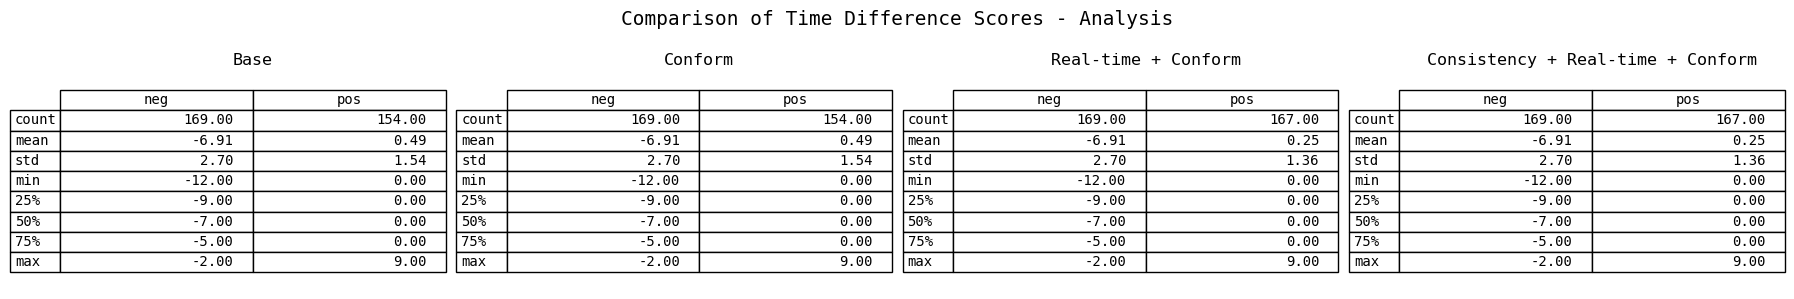

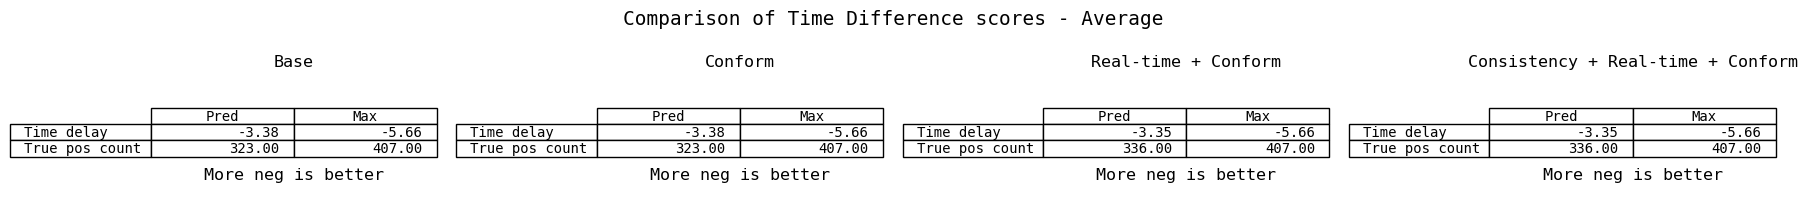

In [53]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",
    "fix_max_ptu_price_known",
    "fix_settlement_price_bestguess_alt",
    "settlement_price_bestguess_alt",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    "month",
    "down_price_volume",
    "up_price_volume",
    "last_15min_up_volume",
    "last_15min_down_volume",
    "downward_dispatch_published_peak",
    "downward_dispatch_published_peak_time",
    "downward_dispatch_published_peak_diff",
    "igcc_contribution_down_published_peak",
    "igcc_contribution_down_published_peak_time",
    "igcc_contribution_down_published_peak_diff",
    "min_price_published_1",
    "max_price_published_1",
    "fix_two_sided_ptu_17",
    "settlement_price_realized_17",
    "minute_in_ptu_2"
]

print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False, test_percentage=0.5)

def train(train_in, train_out, params={}, splits=10):
    """Train a model with grid search"""
    cv = TimeSeriesSplit(n_splits=splits)
    regressor = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")

    model = GridSearchCV(estimator=regressor, param_grid=params, scoring='r2',
                         refit=True, cv=cv.split(train_in), n_jobs=-1, verbose=0)
    model.fit(train_in, train_out)
    best_model = model.best_estimator_
    return best_model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5), pred

mask = splits[train_set][3]["started_down"]

t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
mask = mask & t



X_train = splits[train_set][0][mask]
y_train = splits[train_set][1][mask]

best2, _ = evaluate_income(train, test, X_train, y_train, splits[test_set][0], splits[test_set][3], repeat=1)

p2, p2p = test(best2[0], splits[test_set][0])
p = p2
show_metrics_adjusted(splits[test_set][3], p, version=version)

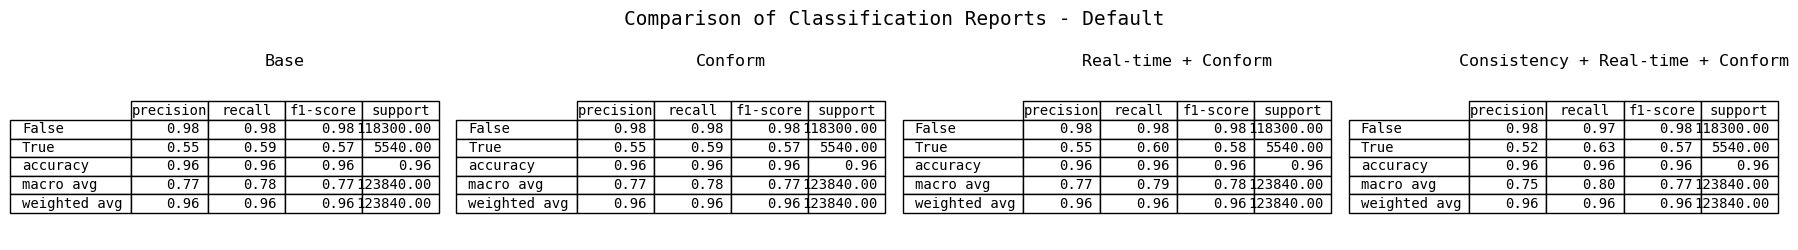

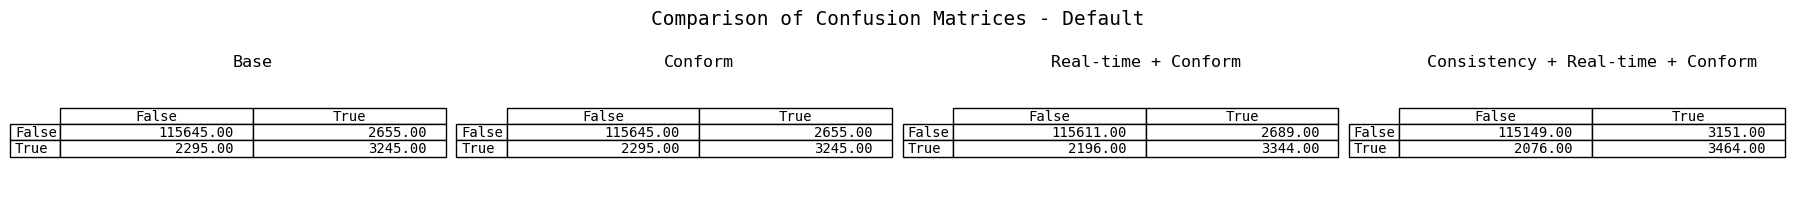

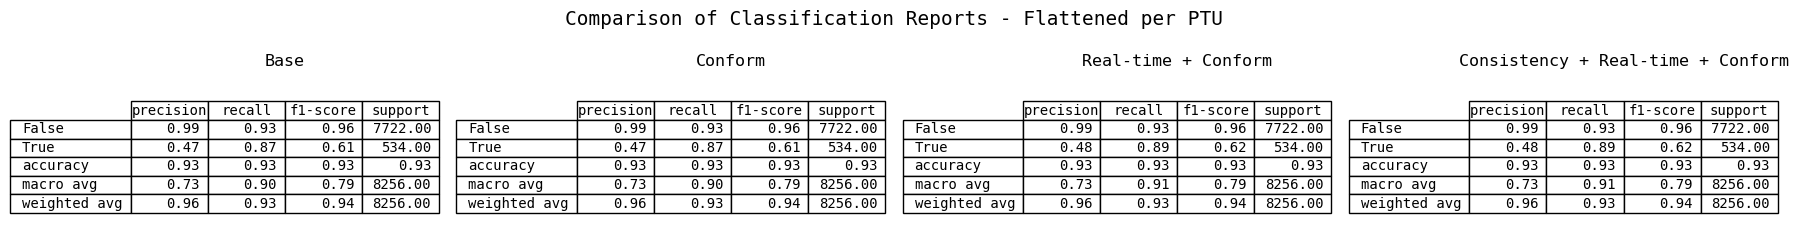

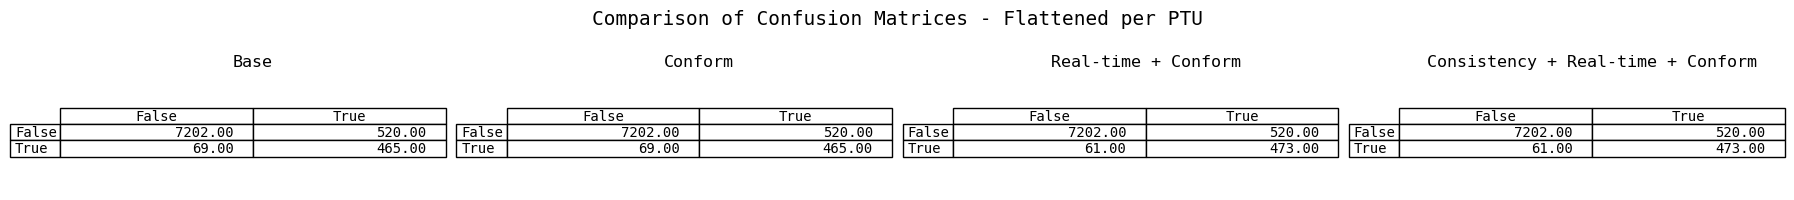

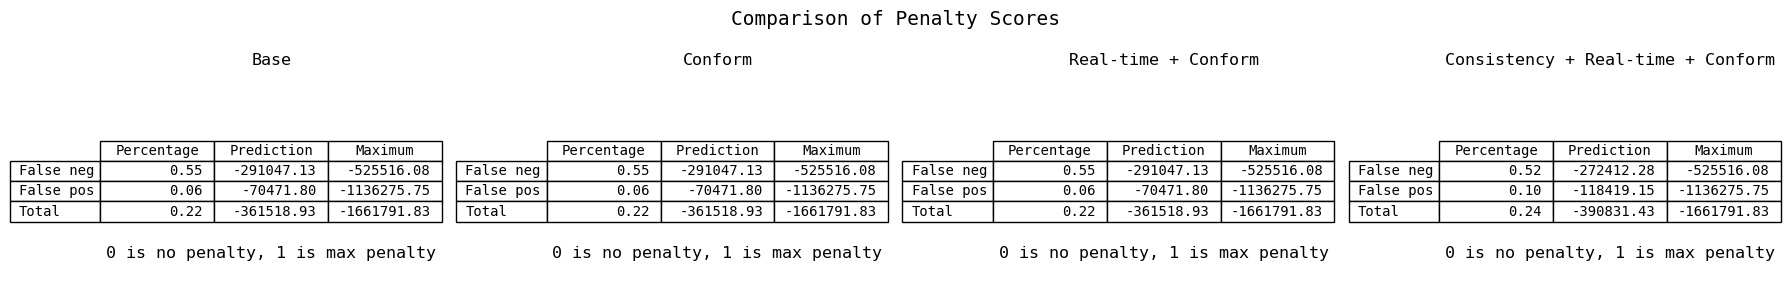

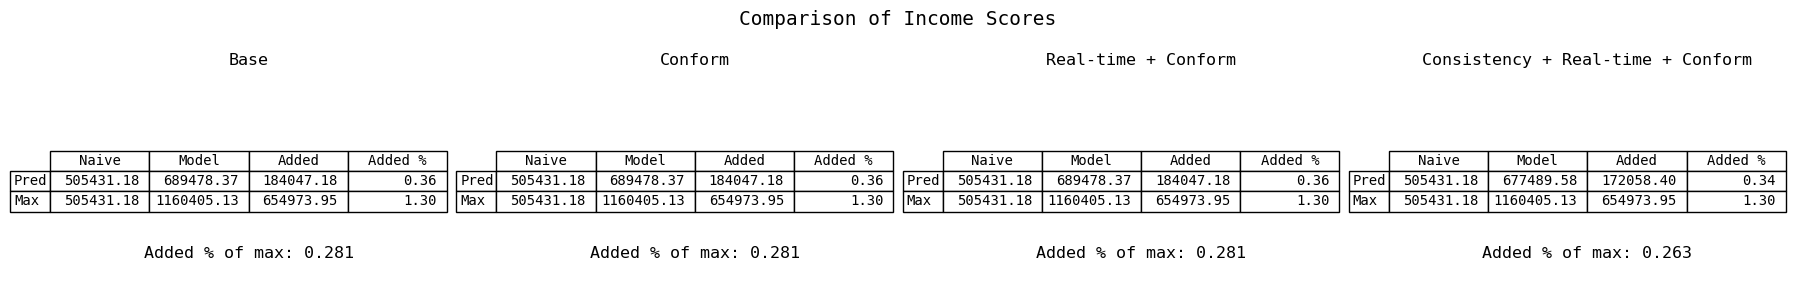

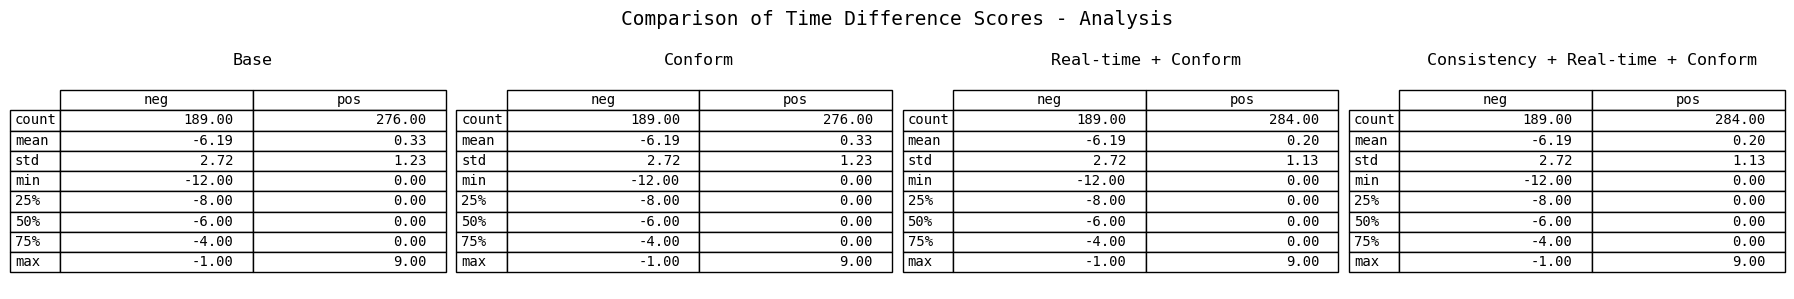

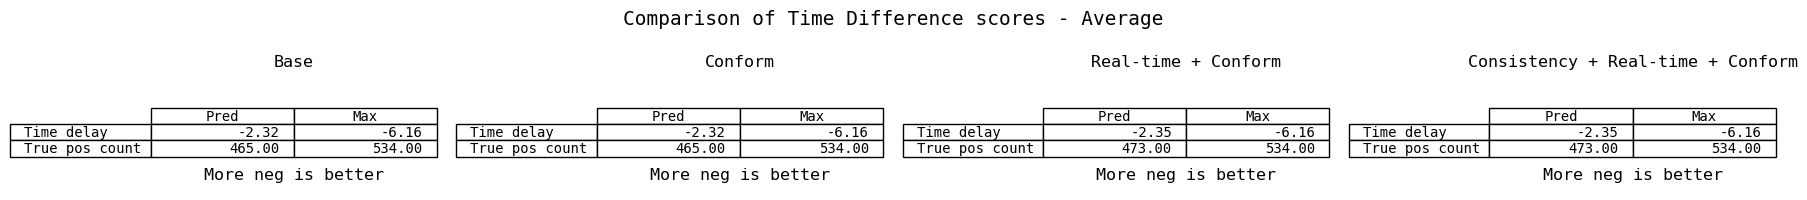

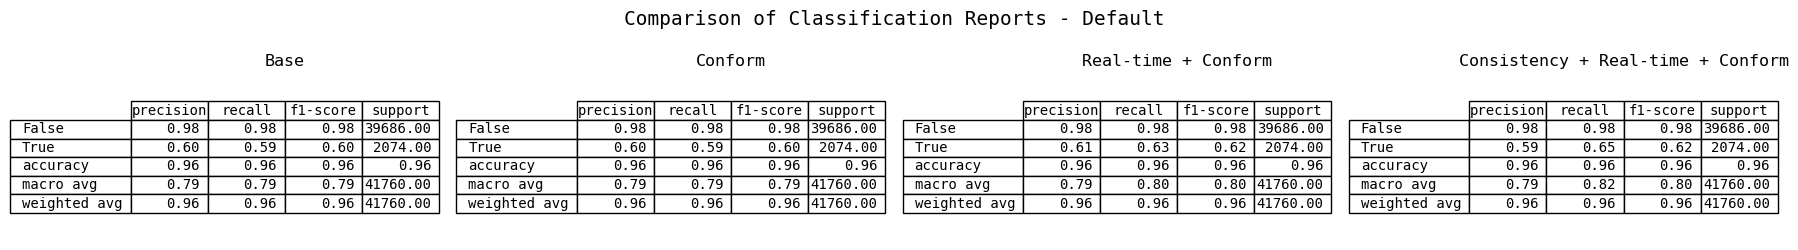

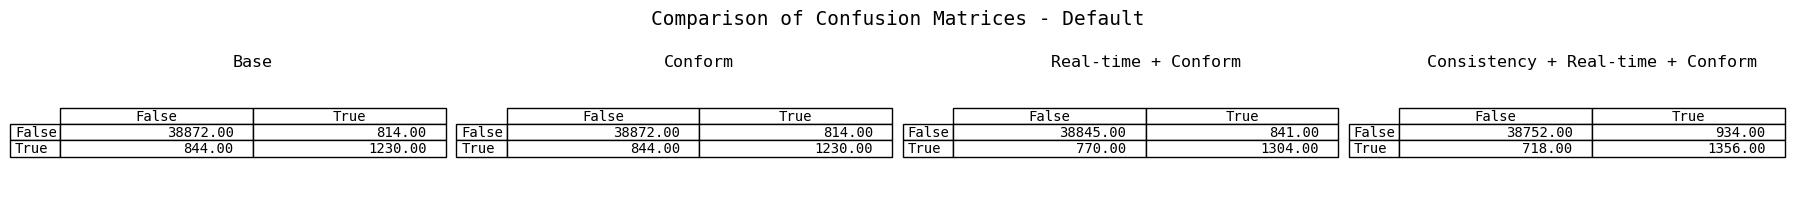

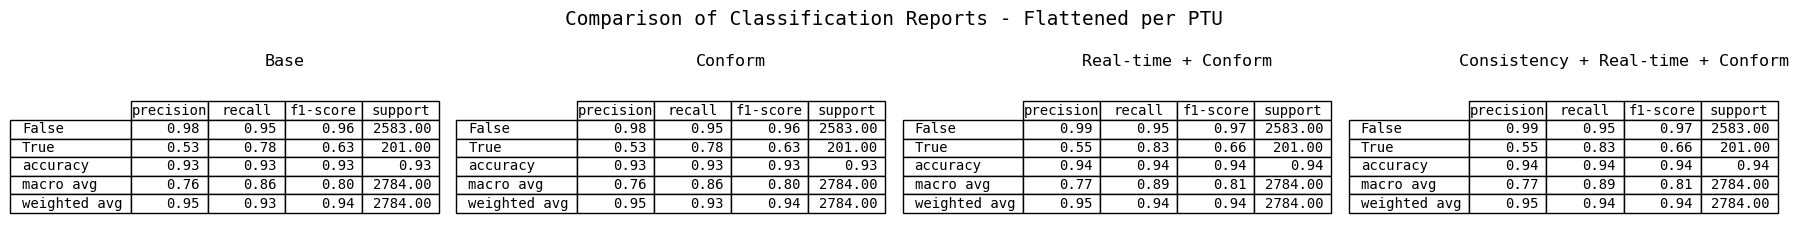

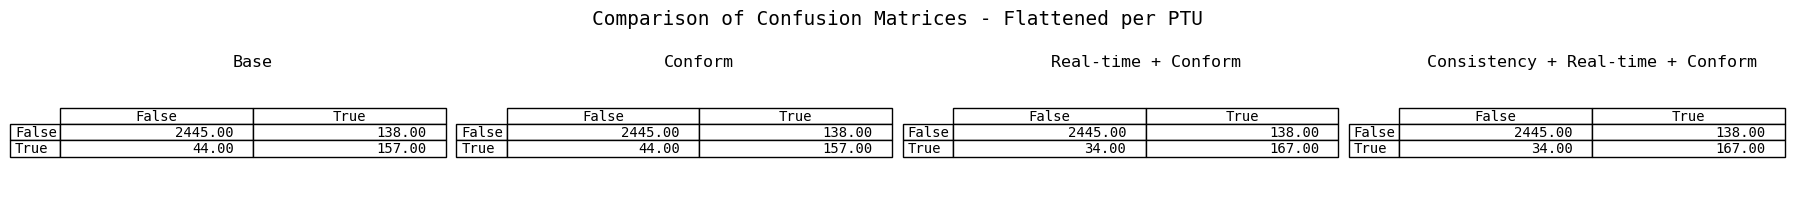

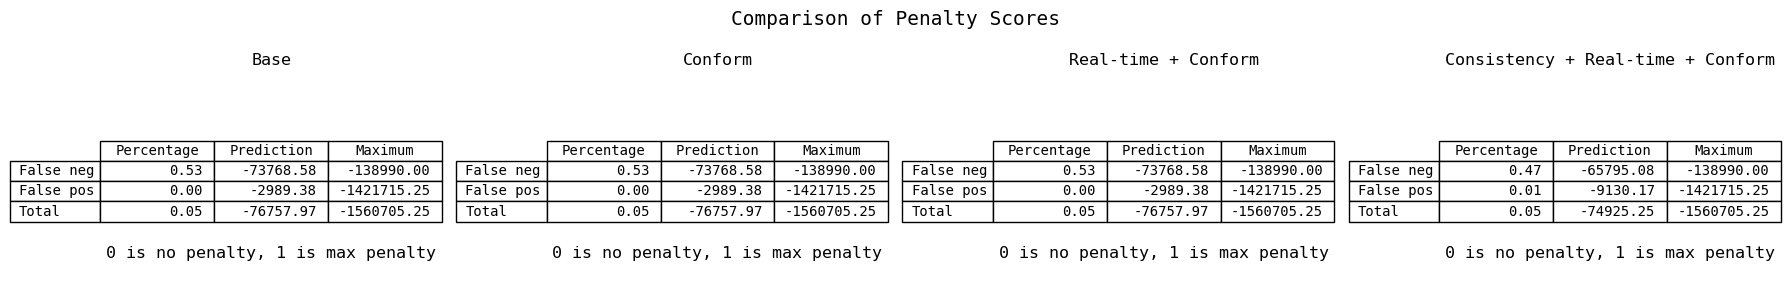

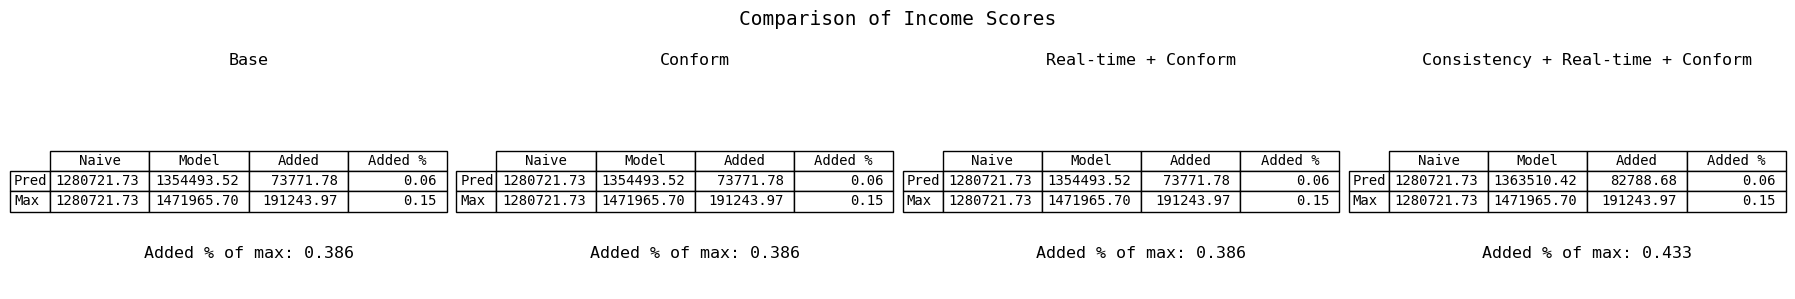

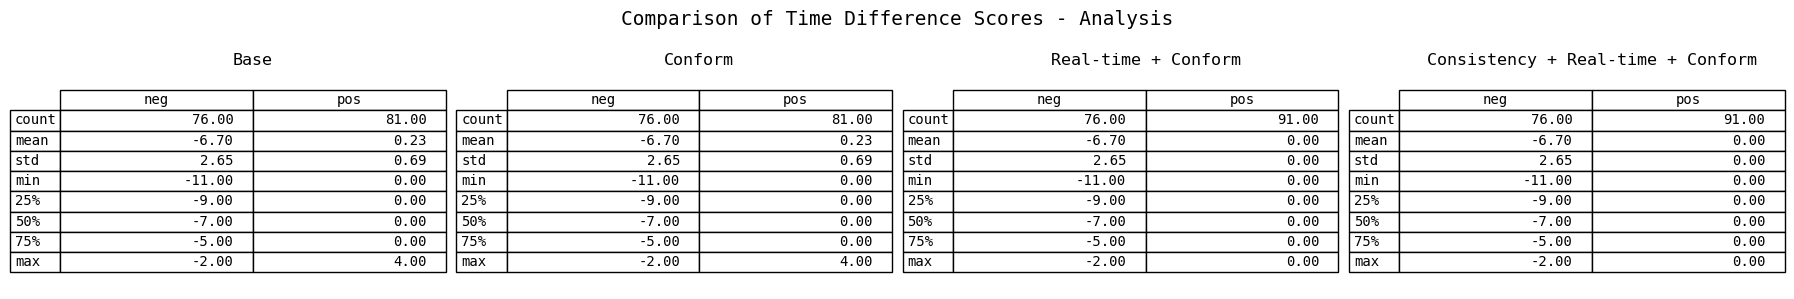

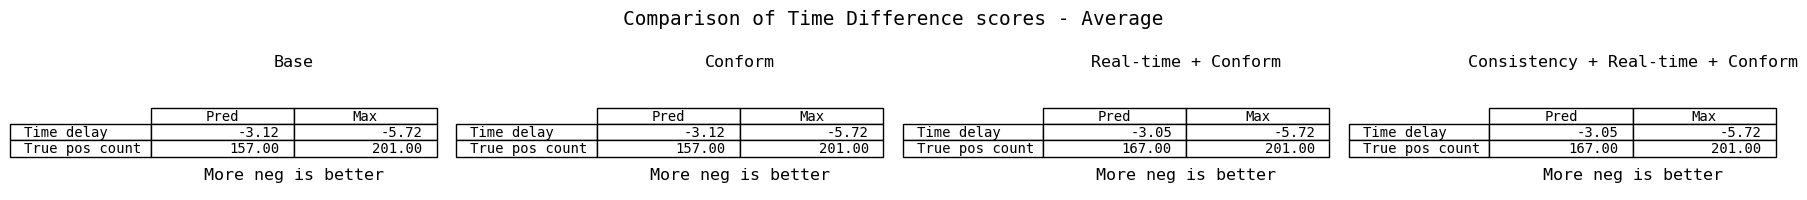

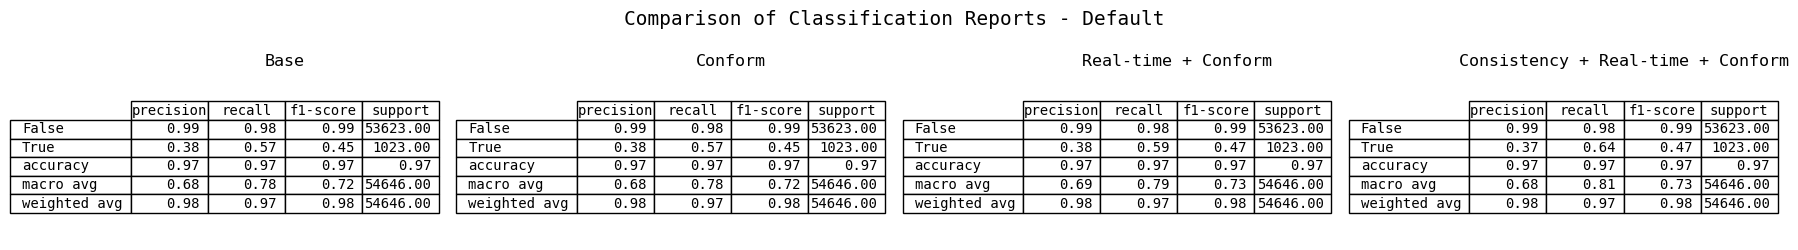

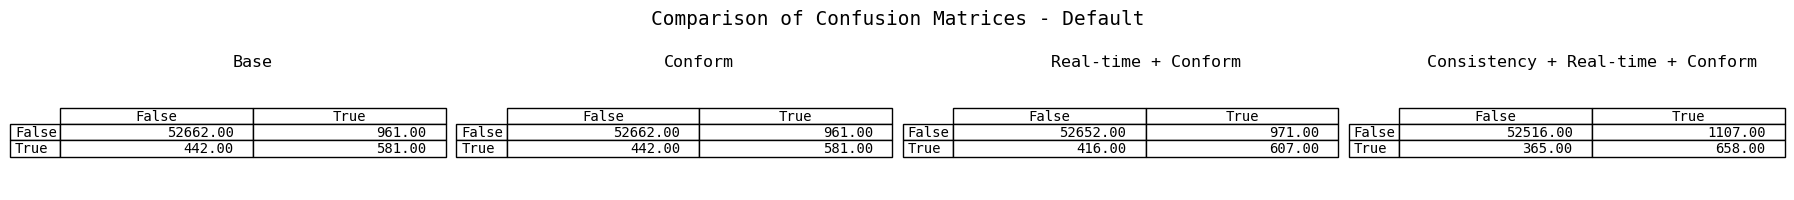

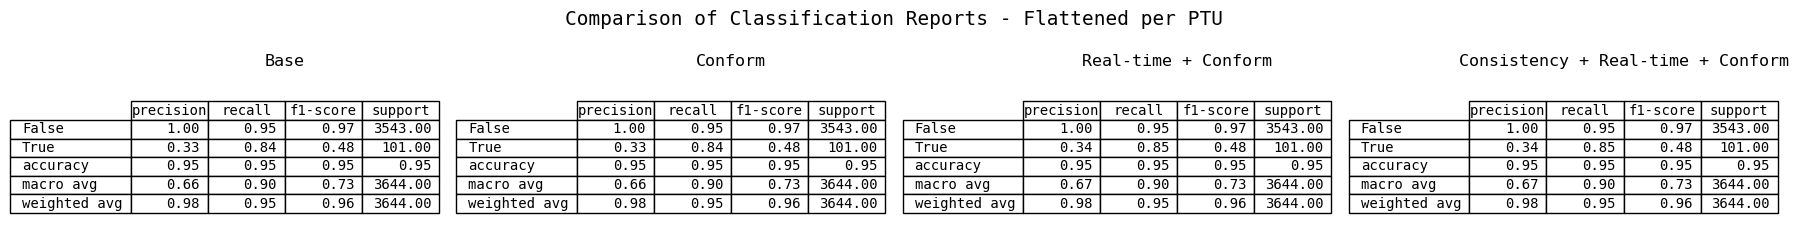

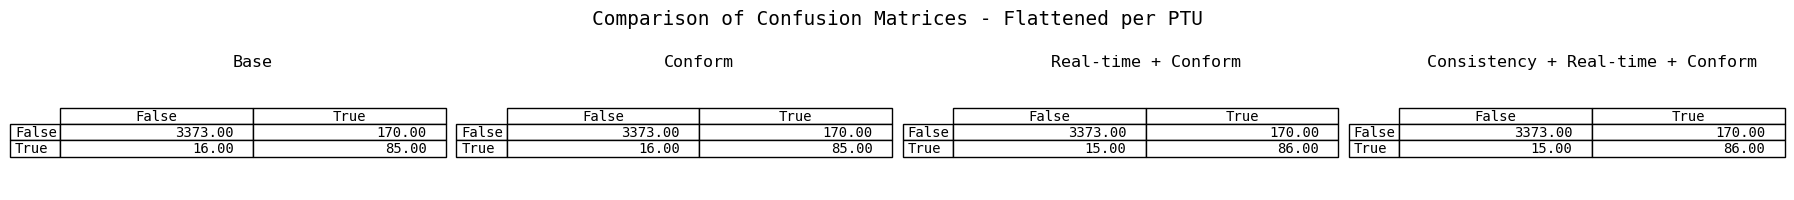

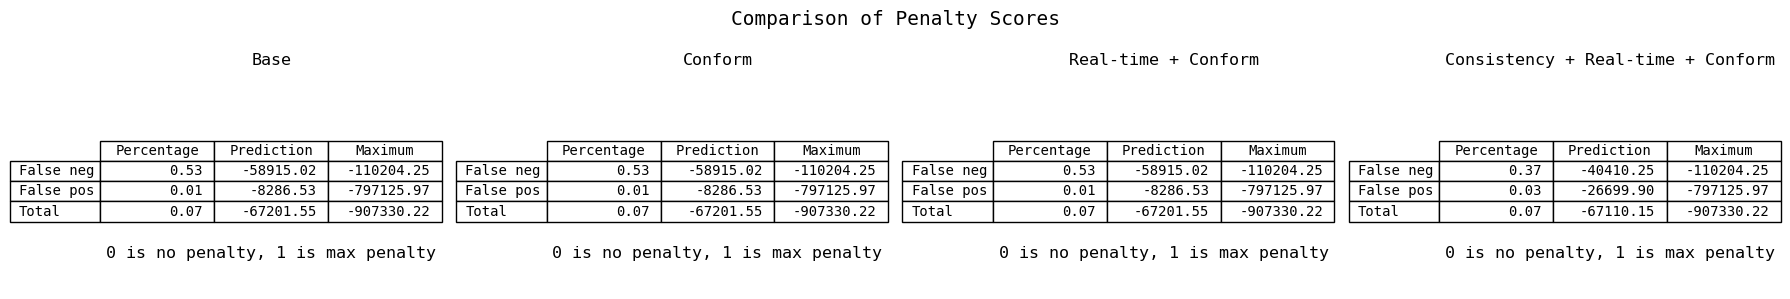

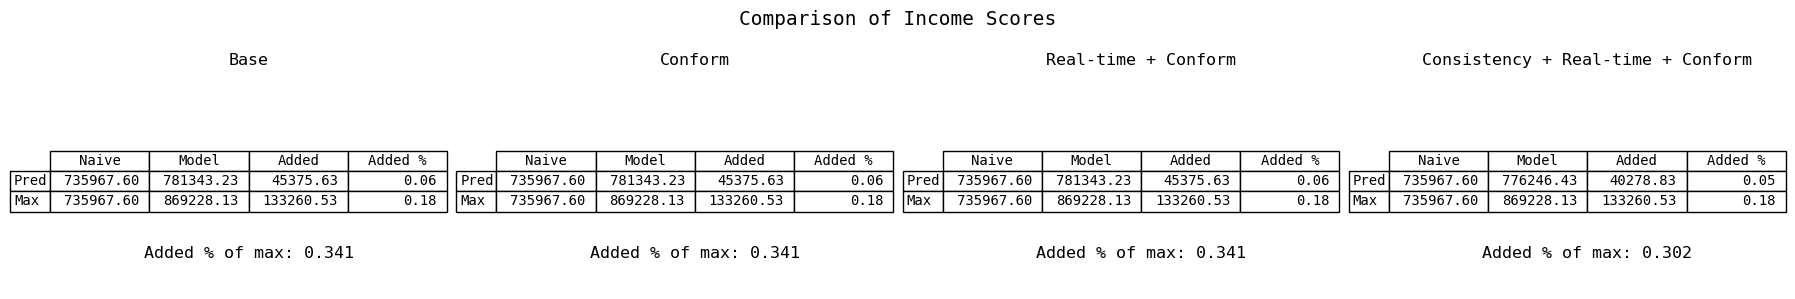

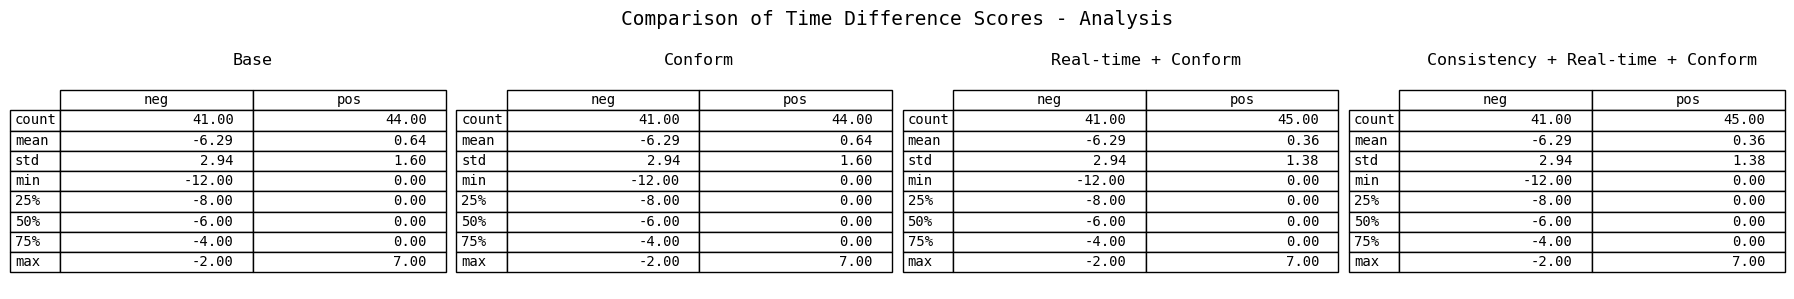

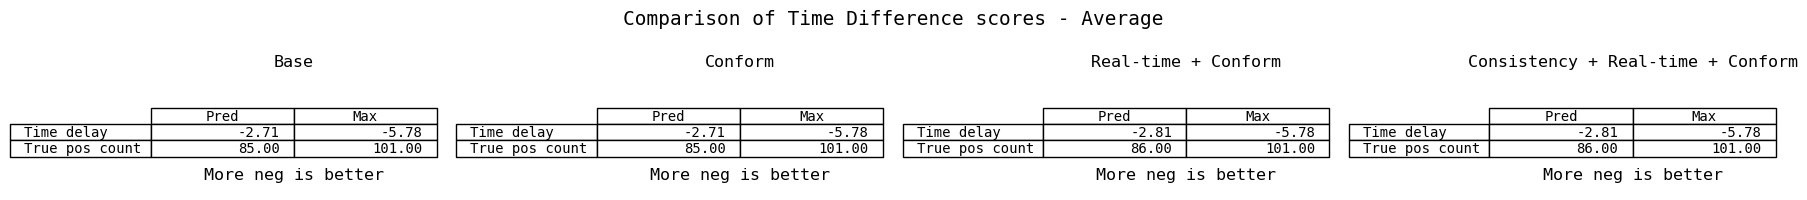

In [54]:
splits_eval = get_splits(df, features, target, return_dict_pair=False)

p_tr, _ = test(best2[0], splits_eval["train"][0])
show_metrics_adjusted(splits_eval["train"][3], p_tr, version=version)

p_va, _ = test(best2[0], splits_eval["valid"][0])
show_metrics_adjusted(splits_eval["valid"][3], p_va, version=version)

p_te, _ = test(best2[0], splits_eval["test"][0])
show_metrics_adjusted(splits_eval["test"][3], p_te, version=version)

In [55]:
save_model(best2[0], "hgbr", "main_model")

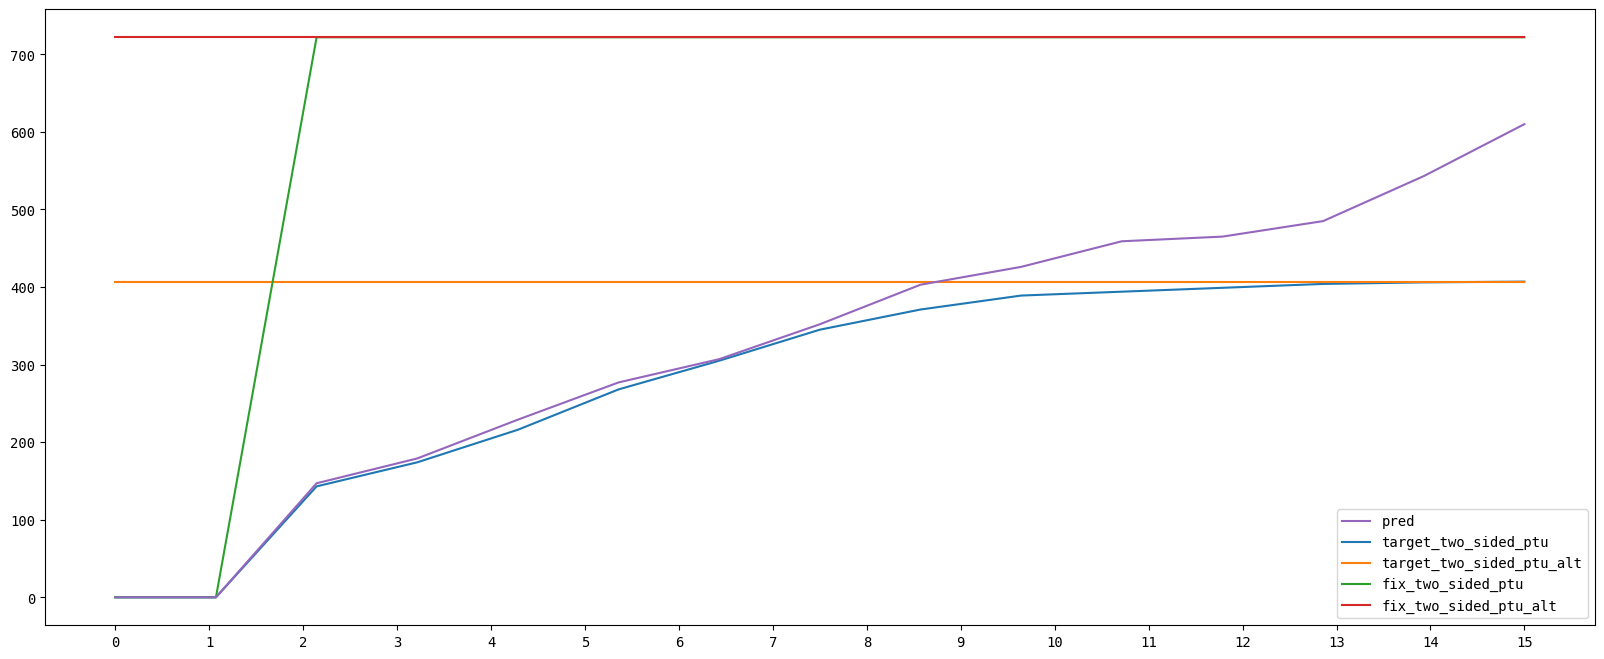

In [56]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p2
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()